In [3]:
import os, sys
os.chdir(os.path.dirname(os.getcwd()))

In [4]:
import shutil
import glob
import time
import argparse
import json
from easydict import EasyDict
import copy
import pprint
from collections import namedtuple

import math
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', None)
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchcontrib
import torch.backends.cudnn as cudnn

import fastai
from fastai.basic_data import DataBunch
# from fastai.vision import Learner
from modules.blend_data_augmentation import Learner
from fastai.distributed import setup_distrib, num_distrib

from tqdm import tqdm
from functools import partial

import models.model_list as model_list
from modules.adabound import AdaBound
from modules.ranger913A import Ranger
from modules.train_annealing import fit_with_annealing
import modules.swa as swa
from utils.dataloader import get_data_loaders, get_fastai_data_bunch
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from utils.losses import MosLoss
from utils.metrics import accuracy, macro_f1, genus_accuracy, species_accuracy,\
                            genus_f1_score, species_f1_score
from utils.misc import log_metrics, cosine_annealing_lr
from utils.callbacks import SaveBestModel, WandbCallback
from utils.vis_utils import plttensor

# from utils.logger import Logger as TfLogger
# from tensorboardX import SummaryWriter
import wandb

from configs.old_configs.paper_redo.closed.fold1.config import config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    cudnn.benchmark = True


    
args = EasyDict()
args.dev_mode = False
args.resume = False
args.latest = False
args.realtime = False

pprint.pprint(config)
%matplotlib inline

{'DATA_CSV_PATH': 'data/finale/datasplit_fold1.csv',
 'False_additions': False,
 'alpha': 0.99,
 'ann_start': 0.7,
 'augment_prob': 0.001,
 'batch_size': 16,
 'blend_params': {'alpha': 1.0,
                  'blend_type': 'cut',
                  'fixed_proba': 0,
                  'grid': True,
                  'same_crop': False,
                  'same_image': False,
                  'same_size': False,
                  'size': 0.15},
 'class_map': [(0, 'aedes aedes_aegypti'),
               (1, 'aedes aedes_albopictus'),
               (2, 'aedes aedes_dorsalis'),
               (3, 'aedes aedes_japonicus'),
               (4, 'aedes aedes_sollicitans'),
               (5, 'aedes aedes_vexans'),
               (6, 'anopheles anopheles_coustani'),
               (7, 'anopheles anopheles_crucians'),
               (8, 'anopheles anopheles_freeborni'),
               (9, 'anopheles anopheles_funestus'),
               (10, 'anopheles anopheles_gambiae'),
               (11, 'culex 

In [5]:
pwd

'/home/hieu/Downloads/pace1'

In [6]:
def get_class_map(df):
    class_map = {}
    for i in range(len(df)):
        class_map[df.loc[i, 'Species']] = df.loc[i, 'Species_Name']
    return class_map

In [7]:
cm = get_class_map(pd.read_csv(config.DATA_CSV_PATH))
for i in range(len(cm)):
    print(i, ": ", cm[i])
print(len(cm))

0 :  aedes_aegypti
1 :  aedes_albopictus
2 :  aedes_dorsalis
3 :  aedes_japonicus
4 :  aedes_sollicitans
5 :  aedes_vexans
6 :  anopheles_coustani
7 :  anopheles_crucians
8 :  anopheles_freeborni
9 :  anopheles_funestus
10 :  anopheles_gambiae
11 :  culex_erraticus
12 :  culex_pipiens_sl
13 :  culex_salinarius
14 :  psorophora_columbiae
15 :  psorophora_ferox
16 :  aedes_spp
17 :  anopheles_spp
18 :  culex_spp
19 :  psorophora_spp
20 :  mosquito
21


In [8]:
model_params = [config.exp_name, config.model_name]
MODEL_CKPT = os.path.abspath('./model_weights/{}/best_{}.pth'.format(*model_params))

Net = getattr(model_list, config.model_name)

net = Net(config=config)

gpu = setup_distrib(config.gpu)
opt = config.optimizer
mom = config.mom
alpha = config.alpha
eps = config.eps

if   opt=='adam': opt_func = partial(optim.Adam, betas=(mom,alpha), eps=eps)
elif opt=='adamw': opt_func = partial(optim.AdamW, betas=(mom,alpha), eps=eps)
elif opt=='radam': opt_func = partial(RAdam, betas=(mom,alpha), eps=eps)
elif opt=='novograd': opt_func = partial(Novograd, betas=(mom,alpha), eps=eps)
elif opt=='rms': opt_func = partial(optim.RMSprop, alpha=alpha, eps=eps)
elif opt=='sgd': opt_func = partial(optim.SGD, momentum=mom)
elif opt=='rangervar': opt_func = partial(RangerVar,  betas=(mom,alpha), eps=eps)
elif opt=='ranger': opt_func = partial(Ranger,  betas=(mom,alpha), eps=eps)
elif opt=='ralamb': opt_func = partial(Ralamb,  betas=(mom,alpha), eps=eps)
elif opt=='over9000': opt_func = partial(Over9000,  k=12, betas=(mom,alpha), eps=eps)
elif opt=='lookahead': opt_func = partial(LookaheadAdam, betas=(mom,alpha), eps=eps)
elif opt=='Adams': opt_func=partial(Adams)
elif opt=='rangernovo': opt_func=partial(RangerNovo)
elif opt=='rangerlars': opt_func=partial(RangerLars)

else:
    raise ValueError("Optimizer not recognized")
        
train_ds, valid_ds = get_data_loaders(config, get_dataset=True, one_hot_labels=config.one_hot_labels)
print("Train dataset size = {}".format(len(train_ds)))
data = DataBunch.create(train_ds, valid_ds, bs=config.batch_size,
                         num_workers=config.num_workers)
loss = MosLoss(config=config)

freeze_bn = False
save_imgs = False
train_losses = []
valid_losses = []
valid_f1s = []
lr_hist = []

# callback_fns=[WandbCallback] if (config.wandb and not get_learn) else []

print('Training ...')
print('Saving to ', MODEL_CKPT)
metrics = [partial(accuracy, one_hot_labels=config.one_hot_labels), partial(macro_f1, one_hot_labels=config.one_hot_labels)]

Using Xception with 16 classes
Loading pretrained weights...
Reading data split from data/finale/datasplit_fold1.csv
Data Augmemtation with probability  0.001
Train dataset size = 6863
Focal Loss with gamma =  0
Training ...
Saving to  /home/hieu/Downloads/pace1/model_weights/paper_redo/closed/fold1/best_xception.pth


In [9]:
learn = (Learner(data, net, wd=config.weight_decay, opt_func=opt_func,
         metrics=metrics,
         bn_wd=False, true_wd=True,
         loss_func = loss,
         # loss_func = LabelSmoothingCrossEntropy(),
#          callback_fns=callback_fns,
         model_dir=MODEL_CKPT)
        )

if gpu is None: learn.to_parallel()
elif num_distrib()>1: learn.to_distributed(gpu)

best_save_cb = SaveBestModel(learn, config=config)    

In [10]:
learn.fit_one_cycle(config.epochs, config.lr, div_factor=10, pct_start=0.3, callbacks=[best_save_cb])        

epoch,train_loss,valid_loss,accuracy,macro_f1,time
0,1.764712,1.432741,0.733871,0.527508,01:38
1,0.988066,0.939183,0.822581,0.594615,01:34
2,0.759562,0.683762,0.887097,0.645443,01:35
3,0.566406,0.714012,0.865591,0.614064,01:35
4,0.526813,0.958780,0.843414,0.673228,01:35
5,0.463557,0.506435,0.919355,0.713584,01:35
6,0.472309,1.325889,0.792339,0.597854,01:34
7,0.487593,1.996834,0.685484,0.470283,01:35
8,0.461264,0.504795,0.913306,0.717906,01:35
9,0.508232,0.782653,0.864247,0.653189,01:34


/home/hieu/Downloads/pace1/modules/ranger913A.py:137: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


## Test

In [11]:
%run test.py --metric acc --tta 1 --config 'configs/old_configs/paper_redo/open/fold1/config.py'

configs.old_configs.paper_redo.open.fold1.config

{'DATA_CSV_PATH': 'data/finale/datasplit_fold1.csv',
 'False_additions': False,
 'alpha': 0.99,
 'ann_start': 0.7,
 'augment_prob': 0.001,
 'batch_size': 16,
 'blend_params': {'alpha': 1.0,
                  'blend_type': 'cut',
                  'fixed_proba': 0,
                  'grid': True,
                  'same_crop': False,
                  'same_image': False,
                  'same_size': False,
                  'size': 0.15},
 'class_map': [(0, 'aedes aedes_aegypti'),
               (1, 'aedes aedes_albopictus'),
               (2, 'aedes aedes_dorsalis'),
               (3, 'aedes aedes_japonicus'),
               (4, 'aedes aedes_sollicitans'),
               (5, 'aedes aedes_vexans'),
               (6, 'anopheles anopheles_coustani'),
               (7, 'anopheles anopheles_crucians'),
               (8, 'anopheles anopheles_freeborni'),
               (9, 'anopheles anopheles_funestus'),
               (10, 'anophele

In [12]:
%run test.py --metric acc --tta 1 --features


{'DATA_CSV_PATH': 'data/finale/datasplit_fold1.csv',
 'False_additions': False,
 'alpha': 0.99,
 'ann_start': 0.7,
 'augment_prob': 0.001,
 'batch_size': 16,
 'blend_params': {'alpha': 1.0,
                  'blend_type': 'cut',
                  'fixed_proba': 0,
                  'grid': True,
                  'same_crop': False,
                  'same_image': False,
                  'same_size': False,
                  'size': 0.15},
 'class_map': [(0, 'aedes aedes_aegypti'),
               (1, 'aedes aedes_albopictus'),
               (2, 'aedes aedes_dorsalis'),
               (3, 'aedes aedes_japonicus'),
               (4, 'aedes aedes_sollicitans'),
               (5, 'aedes aedes_vexans'),
               (6, 'anopheles anopheles_coustani'),
               (7, 'anopheles anopheles_crucians'),
               (8, 'anopheles anopheles_freeborni'),
               (9, 'anopheles anopheles_funestus'),
               (10, 'anopheles anopheles_gambiae'),
               (11, 'culex

## Plots

In [13]:
pwd

'/home/hieu/Downloads/pace1'

In [17]:
from configs.old_configs.paper_redo.closed1.fold1.config import config
import pandas as pd
import math
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', None)
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
subm = pd.read_csv('./subm/{}/best_acc.csv'.format(config.exp_name))
(subm['Species'] == subm['SpeciesPred']).sum()/len(subm)

ModuleNotFoundError: No module named 'configs.old_configs.paper_redo.closed1'

In [18]:
def plot_pretty_blue_confusion_matrix(y_true, y_pred, classes,
                                      normalize=False,
                                      title=None,
                                      cmap=plt.cm.Blues,
                                      savepath=None,
                                      figsize=(24,24)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    precisions = np.diag(cm) / np.sum(cm, axis = 0)
    recalls = np.diag(cm) / np.sum(cm, axis = 1)
    print("Precision: ", np.round(precisions, 4))
    print("Recall: ", np.round(recalls, 4))

    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix")

    # print(cm)
    save_df = pd.DataFrame(data=cm, columns=classes)
    save_df.index = classes
    if savepath is not None:
        save_df.to_csv(savepath.replace(savepath.split('/')[-1],'confusion.csv'), index=True)
    else:
        save_df.to_csv('./subm/confusion.csv', index=True)

    fig, ax = plt.subplots(figsize=figsize)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.xticks(fontsize=round(figsize[0]*.5))
    plt.yticks(fontsize=round(figsize[0]*.5))
    ax.set_xlabel('True label',fontsize=round(figsize[0]*.75))
    ax.set_ylabel('Predicted label',fontsize=round(figsize[0]*.75))
    plt.title(label=title,fontsize=round(figsize[0]))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # ax.tick_params(direction='out', length=6, width=2, colors='r',
    #            grid_color='r', grid_alpha=0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # plt.tight_layout()
    plt.gcf().subplots_adjust(bottom=0.25)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            if math.isnan(val):
                val = 0.0
            ax.text(j, i, format(val, fmt),
                    ha="center", va="center", size=round(figsize[0]*.5),
                    color="white" if cm[i, j] > thresh else "black")
    if savepath is not None:
        fig.savefig(savepath)
    return ax

Precision:  [0.9328 0.98   1.     0.9938 1.     0.8889 1.     1.     1.     0.8927 0.976  0.9302 1.     0.575  0.9848 1.    ]
Recall:  [0.9843 0.9515 1.     0.9815 0.9825 0.96   1.     0.9464 0.977  1.     0.8956 0.8511 0.934  0.92   0.9848 0.975 ]
Normalized confusion matrix


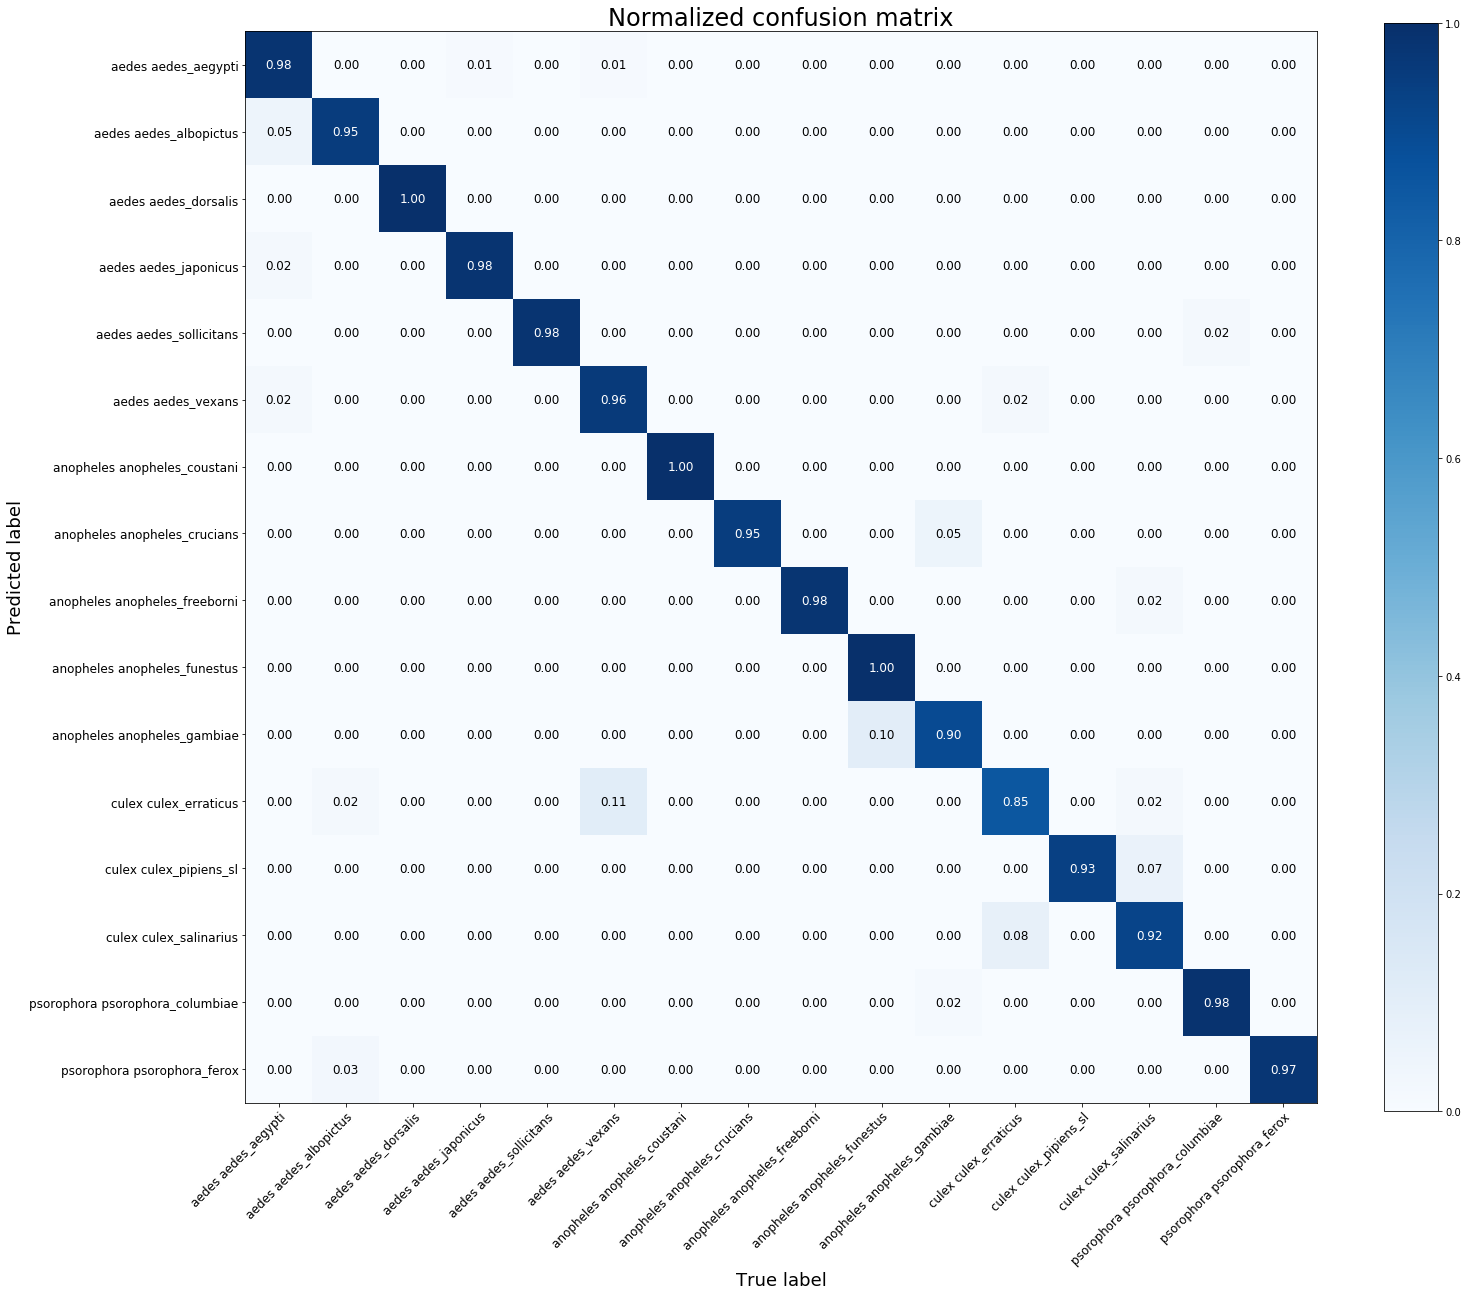

In [19]:
# from post_plots import plot_pretty_blue_confusion_matrix 
plot_pretty_blue_confusion_matrix(subm['Species'], subm['SpeciesPred'],
                      np.array([i[1] for i in config.class_map[:config.num_species.sum()]]), normalize=True,
                      savepath='./subm/{}/confusion_matrix.png'.format(config.exp_name))

In [20]:
#!python post_plots.py --infile ./subm/run68/best_acc.csv

## Generate Features & Probabilities for full dataset

In [21]:
%run test.py --full_df --metric acc --tta 1 --features


{'DATA_CSV_PATH': 'data/finale/datasplit_fold1.csv',
 'False_additions': False,
 'alpha': 0.99,
 'ann_start': 0.7,
 'augment_prob': 0.001,
 'batch_size': 16,
 'blend_params': {'alpha': 1.0,
                  'blend_type': 'cut',
                  'fixed_proba': 0,
                  'grid': True,
                  'same_crop': False,
                  'same_image': False,
                  'same_size': False,
                  'size': 0.15},
 'class_map': [(0, 'aedes aedes_aegypti'),
               (1, 'aedes aedes_albopictus'),
               (2, 'aedes aedes_dorsalis'),
               (3, 'aedes aedes_japonicus'),
               (4, 'aedes aedes_sollicitans'),
               (5, 'aedes aedes_vexans'),
               (6, 'anopheles anopheles_coustani'),
               (7, 'anopheles anopheles_crucians'),
               (8, 'anopheles anopheles_freeborni'),
               (9, 'anopheles anopheles_funestus'),
               (10, 'anopheles anopheles_gambiae'),
               (11, 'culex

RuntimeError: Error(s) in loading state_dict for Xception:
	size mismatch for last_linear.weight: copying a param with shape torch.Size([21, 2048]) from checkpoint, the shape in current model is torch.Size([16, 2048]).
	size mismatch for last_linear.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([16]).

<Figure size 432x288 with 0 Axes>

In [22]:
%run test.py --full_df --metric acc --tta 1 


{'DATA_CSV_PATH': 'data/finale/datasplit_fold1.csv',
 'False_additions': False,
 'alpha': 0.99,
 'ann_start': 0.7,
 'augment_prob': 0.001,
 'batch_size': 16,
 'blend_params': {'alpha': 1.0,
                  'blend_type': 'cut',
                  'fixed_proba': 0,
                  'grid': True,
                  'same_crop': False,
                  'same_image': False,
                  'same_size': False,
                  'size': 0.15},
 'class_map': [(0, 'aedes aedes_aegypti'),
               (1, 'aedes aedes_albopictus'),
               (2, 'aedes aedes_dorsalis'),
               (3, 'aedes aedes_japonicus'),
               (4, 'aedes aedes_sollicitans'),
               (5, 'aedes aedes_vexans'),
               (6, 'anopheles anopheles_coustani'),
               (7, 'anopheles anopheles_crucians'),
               (8, 'anopheles anopheles_freeborni'),
               (9, 'anopheles anopheles_funestus'),
               (10, 'anopheles anopheles_gambiae'),
               (11, 'culex

RuntimeError: Error(s) in loading state_dict for Xception:
	size mismatch for last_linear.weight: copying a param with shape torch.Size([21, 2048]) from checkpoint, the shape in current model is torch.Size([16, 2048]).
	size mismatch for last_linear.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([16]).